In [1]:
# Title: Contact models for atomic force microscopy
# Author: J. P. S. Ferreira
# Date: 2023-01-17
# Description: This notebook is a draft for a work on contact models for atomic force microscopy. It is a work in progress.
# Literature: 
# https://www.sciencedirect.com/science/article/pii/S0968432822000245
# https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-019-3010-3
# License: MIT

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [177]:
def hertz(i, E, nu, r):
    """Hertz model for indentation.
    
    approximation for parabolic indenter.
    Parameters
    ----------
    i : float
        Indentation depth.
    E : float
        Young's modulus.
    nu : float
        Poisson's ratio.
    R : float
        Radius of the indenter.
        
    Returns
    -------
    float
        Contact force.
    """
    a = i/r
    factor = 1 - 0.1 * a - (1/840) * a**2 + (11/15120) * a**3 + (1357/6652800) * a**4
    force = 4/3 * E / (1 - nu**2) * np.sqrt(r)*i**1.5 * factor
    # make nan values zero
    force[np.isnan(force)] = 0
    return force

#Johnson-Kendall-Roberts model for indentation
#https://lizidelcidphd.com/2017/07/07/the-simplified-johnson-kendall-roberts-model/
def jkr(i, E, nu, gamma, r):
    """Johnson-Kendall-Roberts model for indentation.
    
    Parameters
    ----------
    i : float
        Indentation depth.
    E : float
        Young's modulus.
    nu : float
        Poisson's ratio.
    gamma : float
        Surface energy.
    R : float
        Radius of the indenter.
        
    Returns
    -------
    float
        Contact force.
    """
    force = E * r **0.5 * i**1.5 - gamma * E**0.5 * r**0.75 * i**0.75
    # make nan values zero
    force[np.isnan(force)] = 0
    return force

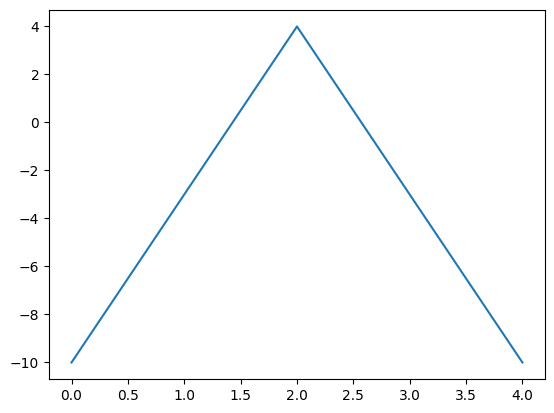

In [224]:
# resolution of the map
res = 20
# random values
size = res * res
# Young's modulus
E = np.random.normal(loc=1.0, scale=0.3, size=size)
# Poisson's ratio
nu = 0.5
# surface energy
gamma = 0.1
# radius of the indenter
r = 1.0
# no contact approach. less points
no_contact = np.linspace(-10, 0, 3)
# indentation depth. more points
contact = np.linspace(0, 4, 20)
# approach and withdraw
approach = np.concatenate([no_contact, contact])
withdraw = np.flip(approach)
ramp = np.concatenate([approach, withdraw])
# define ramp time
half_cycle = 2 
t_approach = half_cycle*((approach - approach.min(axis=0)) / (approach.max(axis=0) - approach.min(axis=0)))
t_withdraw = half_cycle*((withdraw - withdraw.max(axis=0)) / (withdraw.min(axis=0) - withdraw.max(axis=0)))+max(t_approach)
t = np.concatenate([t_approach, t_withdraw])
plt.plot(t, ramp)

In [ ]:
# construct dataframe
df = pd.DataFrame()
df['E'] = E.tolist()
df['approach'] = [approach for _ in range(len(df))]
df['withdraw'] = [withdraw for _ in range(len(df))]
df['f_hertz'] = df.apply(lambda x: hertz(x.approach, x.E, nu, r), axis=1)
df['f_jkr'] = df.apply(lambda x: jkr(x.withdraw, x.E, nu, gamma, r), axis=1)

(4.7, -10.7, -0.8769183682937455, 18.415285734168652)

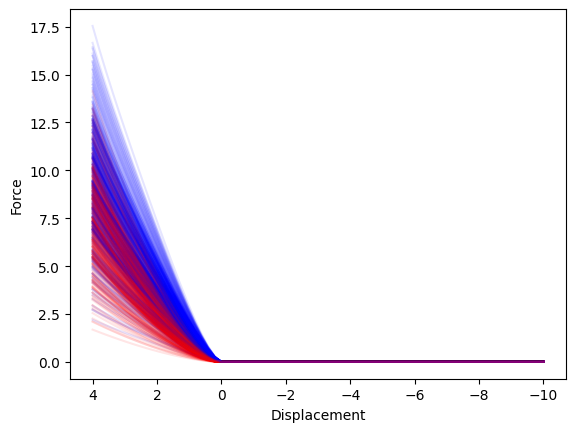

In [192]:
# plot all entries naively
for i, row in df.iterrows():
    plt.plot(row['approach'], row['f_hertz'], color='blue', alpha=0.1)
    plt.plot(row['withdraw'], row['f_jkr'], color='red', alpha=0.1)
#add labels
plt.xlabel('Displacement')
plt.ylabel('Force')
# invert x axis
ax = plt.axis()
plt.axis((ax[1],ax[0],ax[2],ax[3]))

/var/folders/x7/wn0m19s14b134p11_cy_rn540000gn/T/ipykernel_27983/3506622128.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(data=df2, x='approach', y='f_hertz', palette='Set1', errorbar='sd')
/var/folders/x7/wn0m19s14b134p11_cy_rn540000gn/T/ipykernel_27983/3506622128.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(data=df2, x='withdraw', y='f_jkr',  palette='Set2', errorbar='sd')


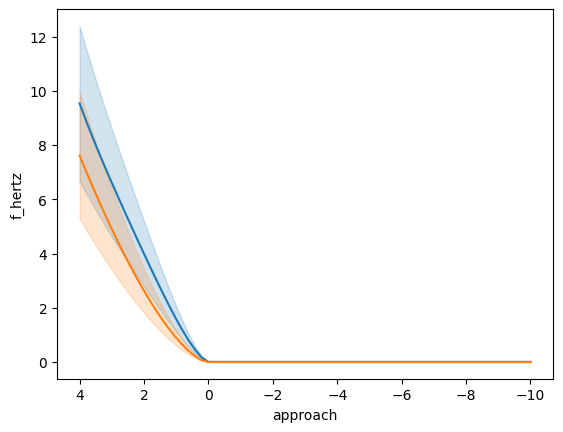

In [193]:
# plot all entries with seaborn
df2 = df.set_index(['E']).apply(pd.Series.explode).reset_index()
ax = sns.lineplot(data=df2, x='approach', y='f_hertz', palette='Set1', errorbar='sd')
ax = sns.lineplot(data=df2, x='withdraw', y='f_jkr',  palette='Set2', errorbar='sd')
ax.invert_xaxis()

<AxesSubplot: >

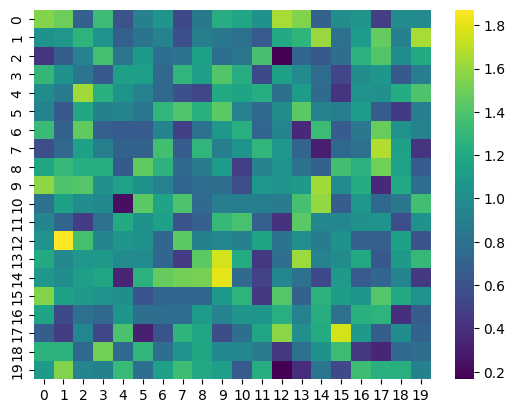

In [188]:
# map random values to a 2D array
E_map = np.reshape(E, (res, res))
# Young's modulus random map
sns.heatmap(E_map, cmap='viridis')
#NOTE: examples at https://seaborn.pydata.org/examples/index.html

<AxesSubplot: >

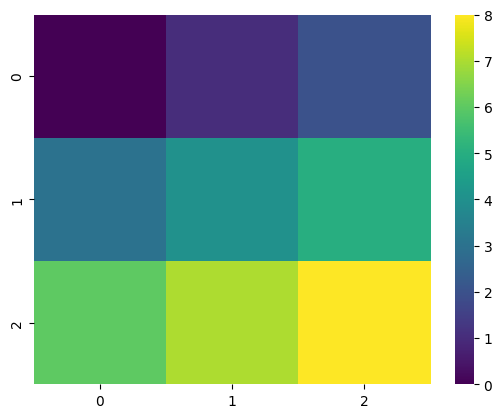

In [149]:
#check reshape rule.
# create sequential integers array of size 9
v = np.arange(0, 9, 1, dtype=int)
# reshape to 3x3
vmap = np.reshape(v, (3, 3))
# print array
sns.heatmap(vmap, cmap='viridis')
#NOTE: reshape rule is row-major, i.e. the first index is the row index. The second index is the column index.